# 

# LangGraph Testing
I will be going through [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/) to figure out how to build chatbots with LangGraph, and how that might be useful with PassionAI as well as learning it for internship work.

## Importing packages & loading env

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_core.messages import ToolMessage

import os, json
from dotenv import load_dotenv

from IPython.display import Image, display

# load env
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_KEY")

## Setting up Basic LangGraph
- Setting up `StateGraph` which will be the workflow of the chatbot
- Setting `OPENAI_API_KEY` as an environment variable
- Initializing `GPT-4o` chat model with `init_chat_model`

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
llm = init_chat_model("openai:gpt-4o")

## Adding Nodes
- Adding a chatbot node to the `StateGraph`
    - `llm.invoke()` is the equivalent of making an API call to OpenAI (or the LLM of choice) and extracting the message content
    - `state["messages"]` is an instance of `State` we defined in the last code block
    - The `graph_builder` above has `StateGraph(State)`, which means the StateGraph can receive a `State` as input and output an update to that `State`
    - So, we return `"messages"` to update the `State`. The `add_messages` function when we defined `messages` as `Annotated` will append messages instead of overwriting
    - We then finally add this function and associate it with a node we name "chatbot"
- `START` defines the point where the chatbot will start per run
    - `add_edge` defines a directed edge, otherwise the nodes are just floating around
- We then compile from the graph builder

In [4]:
def chatbot(state: State):
    res = llm.invoke(state["messages"])
    return {"messages": [res]}

# add node with name "chatbot" and function chatbot
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot") # start node

# compile graph
graph = graph_builder.compile()

Displaying graph separately so we don't try to add nodes twice in the same kernel instance.

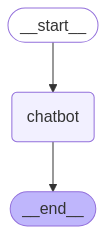

In [5]:
# display graph
display(Image(graph.get_graph().draw_mermaid_png()))

## Part 2: LangGraph w/ Tavily Search
- In this step we use `TavilySearch`, a package designed for searching for information an AI does not know
- We create a new node with function `chatbot_tools`
- We bind tools to the LLM (OpenAI in this case) with `llm.bind_tools(list of tools)`

In [ ]:
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearch(max_results=2)
# print(tool.name) # i guess we need to include the tool name
tools = [tool]
# a = tool.invoke("What is Trump's tariff equation?")

def chatbot_tools(state: State):
    res = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(res.tool_calls) <= 1
    return {"messages": [res]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot_tools", chatbot_tools)
graph_builder.add_edge(START, "chatbot_tools")

# llm with tools
llm_with_tools = llm.bind_tools(tools)

## Defining a Tool Node
- We can use a prebuilt `ToolNode` but the following example shows what is going on underneath

In [ ]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# create node and add it to our graph builder
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot_tools",
    route_tools, # instead of a node, use "route_tools" to determine the node we wish to go to
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot_tools")
graph_builder.add_edge(START, "chatbot_tools")
graph = graph_builder.compile()

## Tool Node with prebuilt components
- `ToolNode` replaces `BasicToolNode`
- `tools_condition` replaces `route_tools`

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

# create node and add it to our graph builder
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot_tools",
    tools_condition
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot_tools")
graph_builder.add_edge(START, "chatbot_tools")
graph = graph_builder.compile()

Again, drawing the graph separately

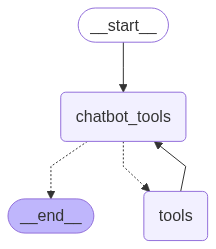

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Part 3: Add memory
- We use an in-memory `MemorySaver`, but there seems to be SQL and Postgres integrations

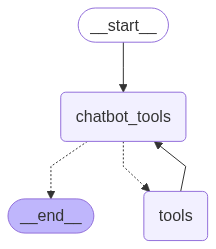

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


## Interacting with memory-enabled chatbot
- Configure a thread ID (any string)
- Ask chatbot, provide information
- Ask follow-up question

In [ ]:
config = {
    "configurable": {
        "thread_id": "zd@5rock.org-ai-1" # change this to change to a "different" thread of memory
    }
}

user_input = input("Enter your query: ")

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input={"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Zach. How can I assist you today?


In [26]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='67942191-f30d-4bbd-aee4-8c200b2b1814'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 768, 'total_tokens': 779, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BWTJlyqTYJ3PQRswwItPfNzU97rhg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--097c071b-9fad-406d-bf48-7bd7ff861aea-0', usage_metadata={'input_tokens': 768, 'output_tokens': 11, 'total_tokens': 779, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(con

## Part 4 & 5: Human-in-the-loop, custom state
- Despite the initial difficulty of setting up tools, adding another tool is as simple as creating a function with a `@tool` decorator, and adding it to the list of tools
- We can update the `State` to track many things at once, updating it and asking the human to confirm whether or not the information is correct

To simplify things, we will copy-paste the code from LangGraph because many variables are spread out over a bunch of code blocks at this point.

The workflow is as follows:
1. Everything pauses with `interrupt`. The graph is paused as well as the tool being run. (`human_assistance(...)` in this case)
2. Everything resumes with `Command(resume={...})`.
3. The function can continue now, and we will reach an `Command(update={...})` which will update the current state explicitly.

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# for this section
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    top_passion: str

graph_builder = StateGraph(State)

# @tool
# def human_assistance(query: str) -> str:
#     """Request assistance from a human."""
#     human_response = interrupt({"query": query})
#     return human_response["data"]

@tool
def human_assistance(name: str, top_passion: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """Request assistance from a human"""

    # interrupt with question and confirmation prompt
    # execution of both function and graph paused
    human_response = interrupt({
        "question": "Please verify that the information below is correct: ",
        "name": name,
        "top_passion": top_passion
    })

    # if the information is correct, update the state without changes
    if human_response.get("correct", "").lower() in ["yes", "y"]:
        verified_name = name
        verified_top_passion = top_passion
        response = "Correct"
    # otherwise, update from user input (hard-coded here, but can be handled as input)
    else:
        verified_name = human_response.get("name", name) # default to previous if nothing is provided
        verified_top_passion = human_response.get("top_passion", top_passion)
        response = f"Human made a correction: {human_response}"

    # explicitly update state with ToolMessage
    state_update = {
        "name": verified_name,
        "top_passion": verified_top_passion,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)]
    }
    print(state_update)

    # return human_response["data"]
    # in the previous example, human_response["data"] would have returned the human response (just a string)
    return Command(update=state_update)

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance] # both tools now can be used by LangGraph
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Now, we build the graph as before:

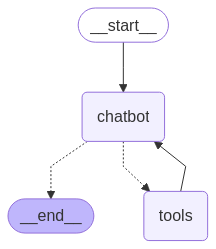

In [74]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

We can then test the chatbot with a question that will require human input.

In [68]:
config = {"configurable": {"thread_id": "zd@5rock.org-ai-2"}}
# user_input = "I need to speak to someone who can speak at length about fluffy space cats."
user_input = (
    "Can you look up the top passion for me, Zachary Deng? "
    "When you have the answer, use the human_assistance tool for review. "
)

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up the top passion for me, Zachary Deng? When you have the answer, use the human_assistance tool for review. 
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_twiQb9fPVn7BmLioTf4ZJABP)
 Call ID: call_twiQb9fPVn7BmLioTf4ZJABP
  Args:
    name: Zachary Deng
    top_passion: Saving


In [55]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

We will simulate getting human input. Examples for both cases: a simple `State` with just a message array, and a complex `State` with `'name'` and `'top_passion'` fields are included.

In [63]:
# human_response = (
#     "Yes, fluffy space cats are just like cats, except they are extremely fluffy, colored either light green or turquoise."
#     " They do not require a space suit to breathe, but require a near-complete absence of oxygen to survive, as oxygen will cause them to suffocate."
# )
# human_command = Command(resume={"data": human_response})

human_command = Command(
    resume={
        "name": "Zachary Deng",
        "top_passion": "Saving"
    }
)

events = graph.stream(
    human_command,
    config,
    stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_abrO73iPuknNQAsO5Si8RjwY)
 Call ID: call_abrO73iPuknNQAsO5Si8RjwY
  Args:
    name: Zachary Deng
    top_passion: Zachary Deng is passionate about the intersection between games and AI, aiming to create fun, educational experiences that leverage technological advancements to bring people together. Additionally, he enjoys designing and writing software.
{'name': 'Zachary Deng', 'top_passion': 'Saving', 'messages': [ToolMessage(content="Human made a correction: {'name': 'Zachary Deng', 'top_passion': 'Saving'}", tool_call_id='call_abrO73iPuknNQAsO5Si8RjwY')]}
================================= Tool Message =================================
Name: human_assistance

Human made a correction: {'name': 'Zachary Deng', 'top_passion': 'Saving'}
================================== Ai Message ==================================

Zachary Deng's top passion has been corrected to "Saving

See that the values have been updated.

In [66]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "top_passion")}

{'name': 'Zechariah Dengerous the Third', 'top_passion': 'Saving'}

You can even override manually.

In [65]:
graph.update_state(config, {"name": "Zechariah Dengerous the Third"})

{'configurable': {'thread_id': 'zd@5rock.org-ai-2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02f7c0-eb53-670c-8006-5d14624e5f95'}}

## Part 6: Time Travel
This part will use a simple LLM without tools.

In [76]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o")

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

Adding steps to the graph.

In [77]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "My name is Zach."
                    "Can you do some research on cats in space?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Zach.Can you do some research on cats in space?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_c2AE0EzIC5cCU6FrS7w4AvhC)
 Call ID: call_c2AE0EzIC5cCU6FrS7w4AvhC
  Args:
    query: cats in space history
================================= Tool Message =================================
Name: tavily_search

{"query": "cats in space history", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "The Untold Truth Of Felicette, The Only Cat Sent To Space", "url": "https://www.grunge.com/655838/the-untold-truth-of-felicette-the-only-cat-sent-to-space/", "content": "Throughout the entire history of spaceflight, only one cat has been successfully launched into space: a black-and-white female named Félicette in 1963.", "score": 0.82254606, "raw_content": null}, {"title": "Félicette - Wikipedia", "url": "https://

Add another step to the graph. 

In [78]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "That sounds great. Maybe I can launch my own"
                    " cat into space, too!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

That sounds great. Maybe I can launch my own cat into space, too!
================================== Ai Message ==================================

Launching a cat into space is a complex and ethically sensitive endeavor. It's important to consider the well-being and safety of animals in such situations. Félicette's mission occurred in a very different context and time, and current standards for animal welfare in experiments are much more stringent.

If you're interested in space and want to involve animals, perhaps consider supporting or learning more about ethical scientific research that benefits both humans and animals. There are many ways to engage with space exploration without directly involving live animals.


Replaying the full state history:

In [86]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
-----------------------------------------------

In [87]:
print(to_replay.next)
print(to_replay.config)

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02f7e3-3db9-65ca-8006-7b3c97ca2eb5'}}
================================== Ai Message ==================================

Launching a cat into space is a complex and ethically sensitive endeavor. It's important to consider the well-being and safety of animals in such situations. Félicette's mission occurred in a very different context and time, and current standards for animal welfare in experiments are much more stringent.

If you're interested in space and want to involve animals, perhaps consider supporting or learning more about ethical scientific research that benefits both humans and animals. There are many ways to engage with space exploration without directly involving live animals.


## Run chatbot
- We run a loop that calls a `stream_graph_updates` function. It looks like we update the graph with user messages using `.stream()` and get the last message of the "messages" array

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        input={"messages": [{"role": "user", "content": user_input}]},
        config=config,
        stream_mode="values"
        ):
        if "messages" in event:
            event["messages"][-1].pretty_print()

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break